In [ ]:
'''
    Copyright (c) 2023 Prabhath Chellingi (CS20BTECH11038@iith.ac.in)
    
    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <https://www.gnu.org/licenses/>.
'''

In [46]:
import torch
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sampler import InfiniteSamplerWrapper
import matplotlib.pyplot as plt

import model
import csv

In [47]:
def load_dataset(min_max_scalar, parameters=['Open', 'High', 'Low', 'Close'], target_index=3, img_size=8, predLen=1, train_ratio=0.9):
    apple = yf.Ticker("AAPL")
    df = apple.history(start='2001-01-19', end='2022-05-13', actions=False)
    df = df[parameters]
    data_values = df.values

    scaled_data = data_values

    if min_max_scalar:
        for i in range(len(min_max_scalar)):
            scaled_data[:, i] = min_max_scalar[i].fit_transform(data_values[:, i].reshape(-1, 1)).reshape(-1, )

    X, Y = [], []
    for i in range(len(scaled_data)-img_size**2-predLen):
        a = np.array(scaled_data[i:(i+img_size**2), :])
        X.append(a.T.reshape(-1, img_size, img_size))
        b = np.array(scaled_data[(i+img_size**2):(i+img_size**2+predLen), target_index])
        Y.append(b.reshape(-1))
    
    X = np.array(X)
    Y = np.array(Y)

    tensor_x = torch.Tensor(X) # transform to torch tensor
    tensor_y = torch.Tensor(Y)

    dataset = torch.utils.data.TensorDataset(tensor_x,tensor_y)

    train_size = int(train_ratio * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    return train_dataset, test_dataset

In [48]:
model_path = 'Close_exp1_minmax/mixerModel_1788.pth'
training_losses_path = 'Close_High_Low_Open_Volume_exp1/trainingLoss.csv'
test_losses_path = 'Close_exp1_minmax/testingLoss.csv'
dataset_params = ['Close']
minmax = 1

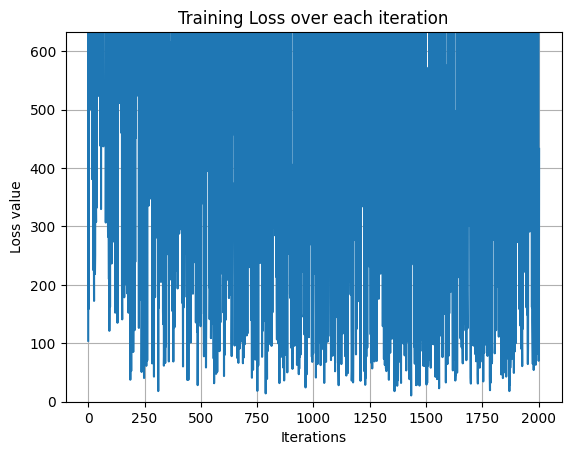

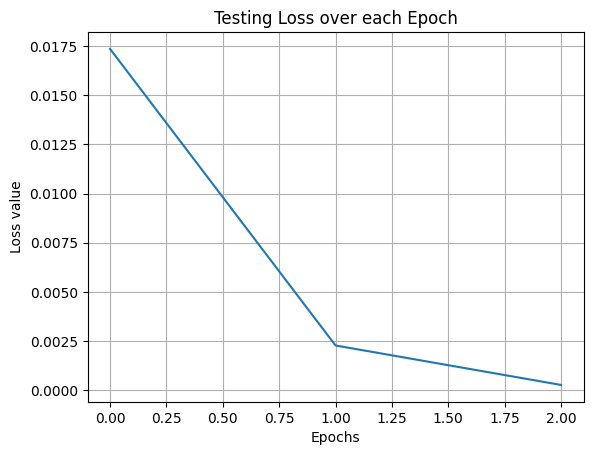

In [49]:
#plotting training_loss and test losses
training_loss = []
with open(training_losses_path, mode ='r') as file:

    # reading the CSV file
    csvFile = csv.reader(file)

    # displaying the contents of the CSV file
    for line in list(csvFile):
        training_loss.append(float(line[0].strip('\n')))

plt.xlabel('Iterations')
plt.ylabel('Loss value')
plt.title('Training Loss over each iteration')
plt.plot(training_loss)
plt.ylim(0, np.mean(training_loss))
plt.grid()
plt.show()

testing_loss = []
with open(test_losses_path, mode ='r') as file:

    # reading the CSV file
    csvFile = csv.reader(file)

    # displaying the contents of the CSV file
    for line in list(csvFile):
        testing_loss.append(float(line[0].strip('\n')))

plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.title('Testing Loss over each Epoch')
plt.plot(testing_loss)
plt.grid()
plt.show()

In [50]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
if minmax:
    min_max_scalar = [MinMaxScaler(feature_range=(0, 1)) for i in range(len(dataset_params))]
else:
    min_max_scalar = None

_, test_set = load_dataset(min_max_scalar, dataset_params, target_index=0, img_size=8, predLen=1, train_ratio=0.9)

test_iter = iter(torch.utils.data.DataLoader(
    test_set, batch_size=4,
    sampler=InfiniteSamplerWrapper(test_set),
    num_workers=4))

mixerModel = model.MLPMixer(in_channels=len(dataset_params), dim=512, num_classes=1, patch_size=4, image_size=(8, 8), depth=16, token_dim=256, channel_dim=2048)

mixerModel.eval()

mixerModel.load_state_dict(torch.load(model_path))

mixerModel.to(device)


cuda


MLPMixer(
  (to_patch_embedding): Sequential(
    (0): Conv2d(1, 512, kernel_size=(4, 4), stride=(4, 4))
    (1): Rearrange('b c h w -> b (h w) c')
  )
  (mixer_blocks): ModuleList(
    (0-15): 16 x MixerBlock(
      (token_mix): Sequential(
        (0): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (1): Rearrange('b n d -> b d n')
        (2): FeedForward(
          (net): Sequential(
            (0): Linear(in_features=4, out_features=256, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=256, out_features=4, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (3): Rearrange('b d n -> b n d')
      )
      (channel_mix): Sequential(
        (0): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (1): FeedForward(
          (net): Sequential(
            (0): Linear(in_features=512, out_features=2048, bias=True)
            (1): GELU(appr

In [51]:
from tqdm import tqdm
predictions = []
groundTruths = []
tqdm_iters = tqdm(range(int(len(test_set)/4)))
for i in tqdm_iters:

    batch, out = next(test_iter)

    pred = mixerModel(batch.to(device))

    predictions += pred.cpu().tolist()
    groundTruths += out.cpu().tolist()

predictions = np.array(predictions)
groundTruths = np.array(groundTruths)

100%|██████████| 132/132 [00:06<00:00, 20.87it/s]


In [52]:
if minmax:
    predictions = min_max_scalar[0].inverse_transform(predictions).flatten()
    groundTruths = min_max_scalar[0].inverse_transform(groundTruths).flatten()

# predictions = np.array(predictions).flatten()
# groundTruths = np.array(groundTruths).flatten()

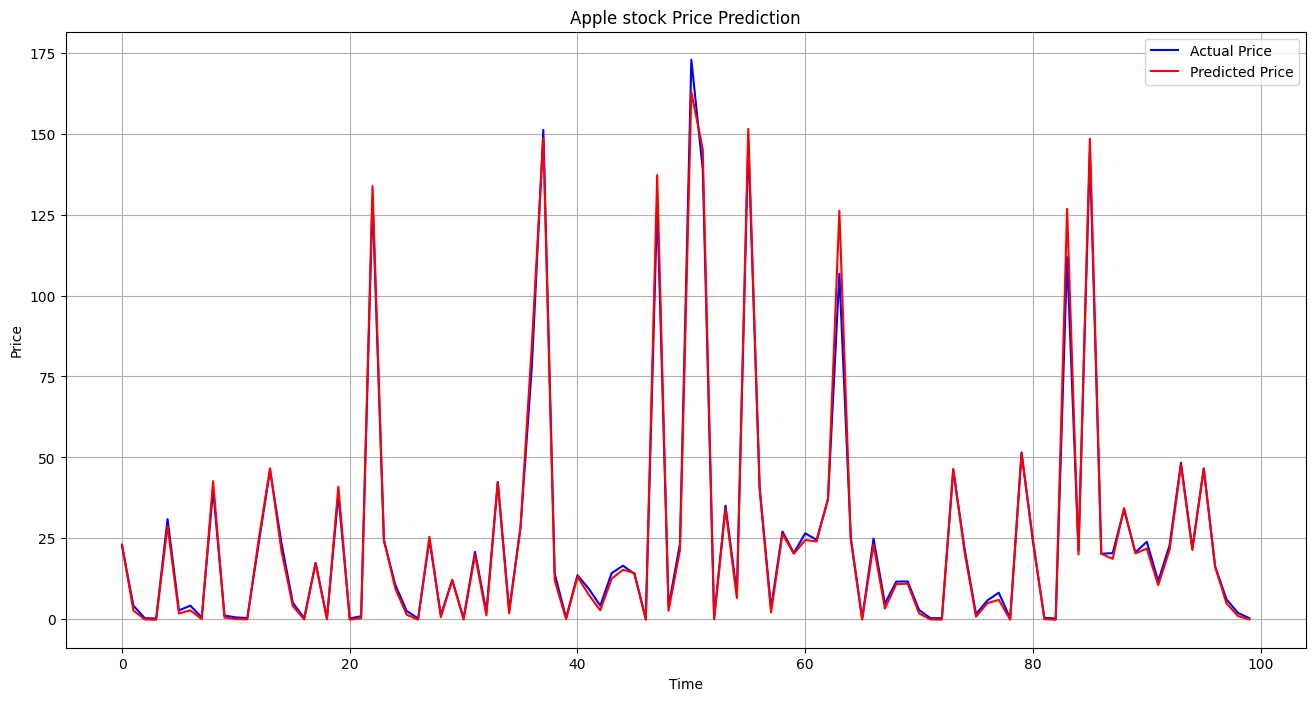

In [53]:
plt.figure(figsize=(16,8))
plt.plot(groundTruths[:100], color='blue', label='Actual Price')
plt.plot(predictions[:100] , color='red', label='Predicted Price')
plt.title('Apple stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

In [54]:
average = sum(abs(0 - predictions[predictions<0]))/(len(predictions[predictions<0])+1e-10)
predictions[predictions<0]  = predictions[predictions<0] + average

print(predictions.shape)
print(groundTruths.shape)

(528,)
(528,)


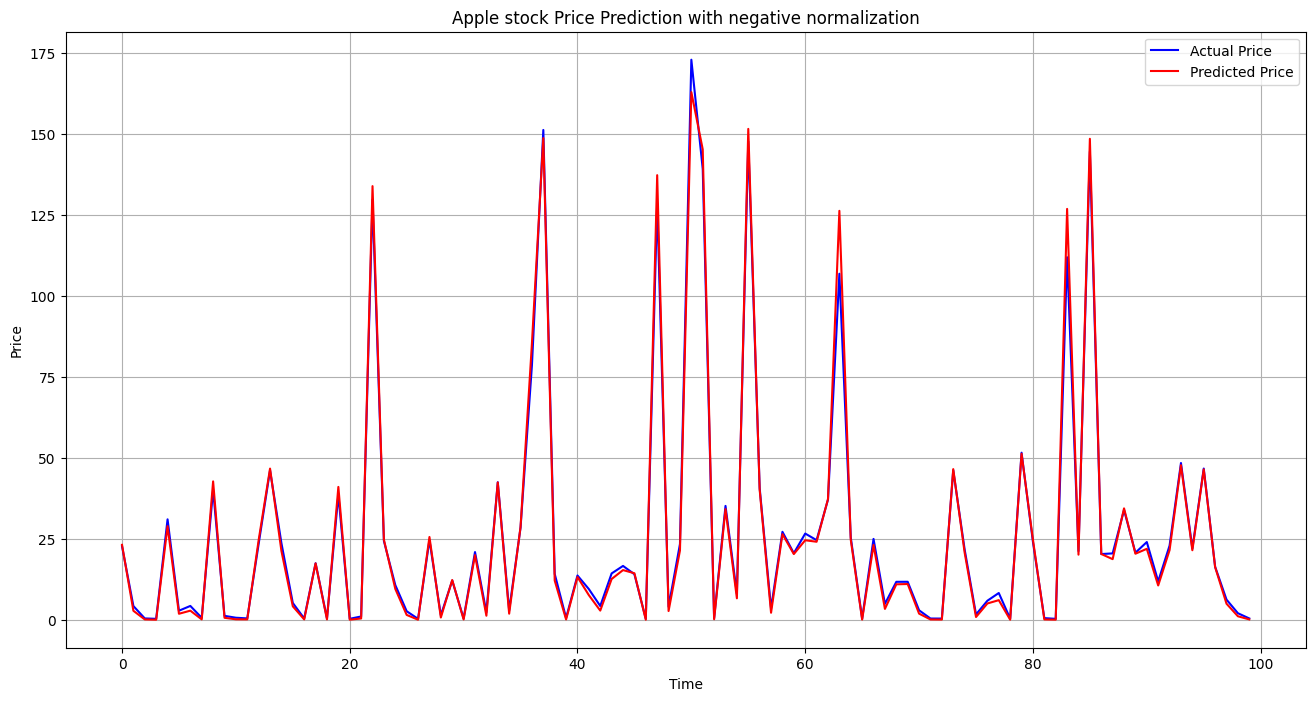

In [55]:

plt.figure(figsize=(16,8))
plt.plot(groundTruths[:100], color='blue', label='Actual Price')
plt.plot(predictions[:100] , color='red', label='Predicted Price')
plt.title('Apple stock Price Prediction with negative normalization')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()